## Codigos necesarios

In [1]:
from funciones_graficar import plot
%matplotlib notebook

# Escogiendo la arquitectura

## ResNet

RestNet o *Residual Network* es una red de convolución profunda para el reconocimiento de imágenes desarrollada por Microsoft.

La idea subyacente en ResNet, es ¿Por qué apilar capas y capas, si a partir de cierta profundidad se ha demostrado (en contra de lo que pudiera parecer) que la red no siempre mejora? De hecho, aparecen problemas como el desvanecimiento del gradiente (vanishing gradient) y la maldición de la dimensionalidad (curse of dimensionality) y la red deja de aprender.

ResNet es una arquitectura donde a diferencia de modelos anteriores, está compuesta de  bloques, donde en cada bloque se usa una "conexión de acceso directo", la cual omite una o más capas.


<figure>
<img src="pics/ResNetExample.png" width="300"/>
    <center><figcaption>Fig.1 </figcaption></center>
</figure>    



Otra característica de ResNet son sus bloques residuales, donde a diferencia de las capas convolucionales comunes, cada capa alimenta a la siguiente capa y directamente a las capas siguientes a unos 2-3 saltos de distancia. Estos bloques ayudan a resolver los problemas anteriormente mencionados (vanish in gradient y curse of dimensionality).


En lugar de esperar que cada pocas capas apiladas encajen directamente en un mapeo subyacente deseado, dejaron explícitamente que estas capas se ajustaran a un mapeo residual.
 
La formulación de residuo F (x) + x  se puede realizar mediante redes neuronales feedforward con conexiones de acceso directo. Las conexiones de acceso directo son aquellas que omiten una o más capas, como se muestra en la Fig. 1. Las conexiones de acceso directo realizan un mapeo de identidad y sus salidas se agregan a las salidas de las capas apiladas. Al utilizar la red residual, hay muchos problemas que se pueden resolver, tales como:

1. Las ResNets son fáciles de optimizar, y a diferencia de las redes "simples" (que simplemente apilan capas),las redes simples, muestran un mayor error de entrenamiento cuando aumenta la profundidad.
 
 
2. ResNets puede ganar precisión fácilmente con una profundidad mucho mayor, produciendo resultados que son mejores que las redes anteriores a esta.


Cada “bloque” ResNet consta de una serie de capas y un mapeo de identidad que agrega una entrada de bloque a la salida. Si la entrada y la salida son de diferentes tamaños, se pueden utilizar técnicas de zero-padding o de proyección (a través de convoluciones de 1×1) para crear las dimensiones correspondientes.


<figure>
<img src=pics/shortRestNet.png width="300"/>
    <center><figcaption>Fig.2 </figcaption></center>
</figure>    


Los atajos de identidad se pueden usar directamente cuando la entrada y la salida son de las mismas dimensiones (flechas de línea de la Fig. 2) pero cuando las dimensiones aumentan (flechas de puntos en la Fig.2), en este caso se consideran dos opciones:

1. El atajo realiza un mapeo de identidad (flecha de línea de la Fig. 2) con un zero-padding para aumentar las dimensiones. Esta opción no introduce ningún parámetro adicional.
 
2. El atajo de proyección se usa para hacer coincidir las dimensiones (hecho por convoluciones 1 × 1).

Para cualquiera de las opciones, si los atajos cruzan features maps de dos tamaños distintos, este se realizó con un paso de 2.


Cada bloque de ResNet puede estar compuesto de 2 capas de profundidad (ResNet 18 y 34) o 3 capas de profundidad (ResNet 50, 101, 152)

Para nuestro caso, utilizaremos ResNet 18, 34 y 50.

<figure>
<img src="pics/ResNetLayers.png" width="600"/>
    <center><figcaption>Fig.3 </figcaption></center>
</figure>

**ResNet 50-Capas:** Cada bloque de 2 capas se reemplaza en la red de 34 capas y con este, 3 capas bottleneck lo que da como resultado una ResNet de 50 capas.

La Unidad Lineal rectificada (ReLU) se usa como función de activación para todas las capas de peso, excepto para la última capa que usa regresión softmax. Una capa completamente conectada termina cada red, de las cuales el número de neuronas corresponde al número de clases.


Fuente imagenes:
*K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.*

# Comparaciones 

```python
np.random.seed(0)
torch.manual_seed(0)
batch_size = 32 #entrenamiento y validacion
```

### Comparación de arquitecturas

Comparamos el desempeño de los modelos pre-entrenados más pequeños de resNet en nuestro dataset de entrenamiento. Este conjunto se separó en dos subconjuntos, uno con un 85% del tamaño original para entrenar y la fracción restante para validar. Se congelaron todas las capas y se reemplazó la cabeza clasificadora de modo que la salida se acomode a nuestro problema (10 clases).

En todos los casos se usó `Adam` como optimizador con una tasa de aprendizaje de 1e-3 y `CrossEntropyLoss` como criterion, el cual es muy utilizado para los problemas de clasificación con C clases, y combina la activación no-linear `LogSoftMax` y la función de pérdida `NLLLoss`


```python
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
```

También se incluye el desempeño de `squeezenet1_1` con el cual se realizaron pruebas en primera instancia.

<IPython.core.display.Javascript object>


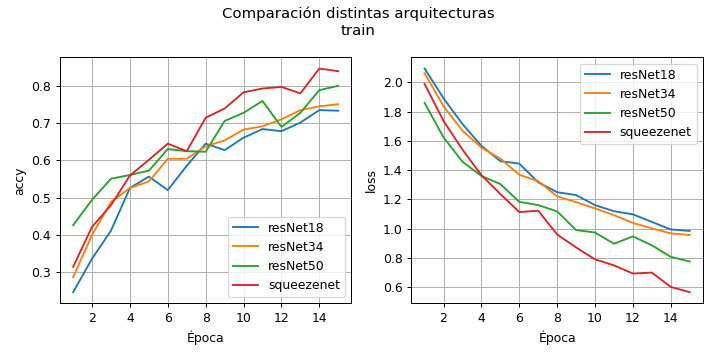

In [26]:
plot("train", "modelos", "Comparación distintas arquitecturas")

<IPython.core.display.Javascript object>


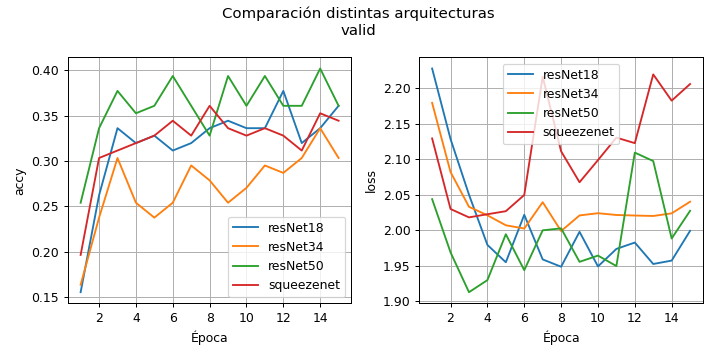

In [27]:
plot("valid", "modelos", "Comparación distintas arquitecturas")

Sin hacer cambios a los modelos pre-entrenados observamos que `resNet50` tiene el mejor desempeño en validación, tanto en accuracy como en loss. Vemos que `squeezenet` se sobreajusta rápidamente a los datos con un buen rendimiento en entrenamiento pero con una loss de validación que empieza a aumentar tras unas pocas épocas. De las tres versiones de resNet, `resNet34` nos entrega los peores resultados en validación.

Debido a lo observado, seleccionamos `resNet50` para entrenar nuestro modelo final.

### Rendimiento de ResNet50 con con distinto número capas descongeladas

Para poder complejizar nuestro modelo determinaremos el número de capas las cuales nos otorguen un mejor rendimiento en loss como en accuracy. Para esto realizaremos pruebas descongelando o re-entrenando las últimas 15, 22 y 30 capas convolucionales de ResNet50

<IPython.core.display.Javascript object>


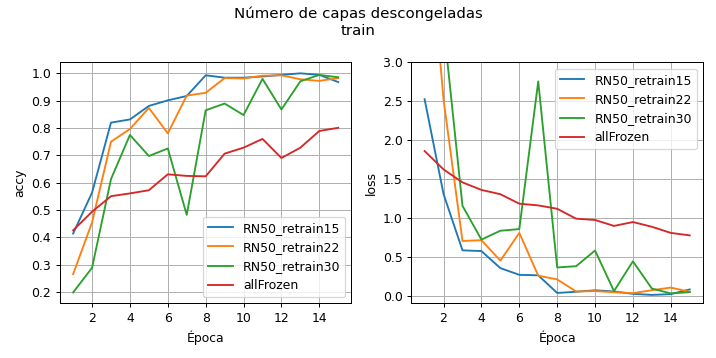

In [28]:
plot("train", "capas", "Número de capas descongeladas")

<IPython.core.display.Javascript object>


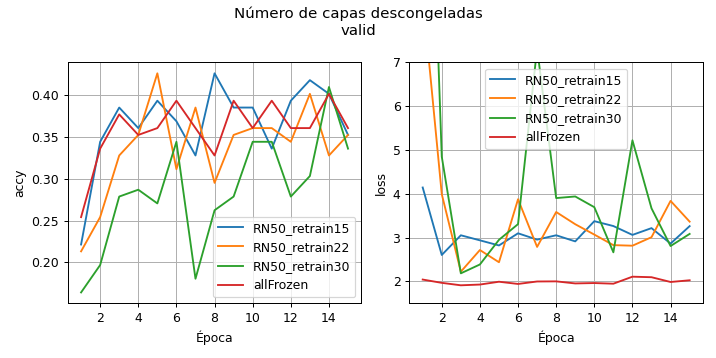

In [30]:
plot("valid", "capas", "Número de capas descongeladas")

 Al descongelar cierto número de capas convolucionales de resNet50 notamos que los modelos se sobre ajustan rápidamente a nuestros datos. Optamos por trabajar descongelando las últimas 15 capas para tener un modelo un poco más complejo, para que pueda aprender filtros relacionados con features específicas de las piezas de arte, con un rendimiento potencial mayor al momento de utilizarlo en el conjunto de prueba.
 
 Cabe destacar que los modelos así como están tienden a sobre ajustarse a los datos, por lo que intentaremos incorporar medidas para enfrentar este problema e intentar disminuir la loss y mejorar el accuracy.


## Medidas para conbatir el sobreajuste

Debido a la complejidad de los modelos base, y a la reducida cantidad de datos que tenemos para entrenarlos, es necesario tomar medidas contra el sobreajuste. Las curvas de aprendizaje de la etapa de validación que acabamos de ver evidencian que esto ocurre rápidamente, tanto al descongelar algunas capas como al trabajar con todas las capas congeladas: la loss de validación disminuye un poco durante las primeras épocas para luego incrementar o estancarse.

Observaremos el efecto que tiene la **aumentación de datos**, al incorporar una transformación al data_loader de entrenamiento, el **dropout** al utilizarlo antes de la capa fully connected del final, y el uso de **weight_decay** en el optimizador junto con la utilización de pesos en el criterion de acuerdo a la cantidad de datos por clase del dataset de entrenamiento.

### Transformaciones

Además de las transformaciones necesarias para utilizar los modelos pre-entrenados, agregamos transformaciones aleatorias de crop, flip y rotación.

```python
train_transform = transforms.Compose([ ...
                        transforms.RandomResizedCrop(size=224,
                                                     scale=(0.2, 1.0)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(degrees=30),
                                      ...
```

### Dropout

```python
neurons = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(p=0.5),
                         torch.nn.Linear(neurons, 10))
```


### Weight

```python
#weight_decay
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-4)
```

```python
#class weight
n_samples = list((Counter(train_data.targets)).values())
normed_weights = [1 - (x / sum(n_samples)) for x in n_samples]
criterion = torch.nn.CrossEntropyLoss(weight=normed_weights)
```

También se utilizó `StratifiedShuffleSplit` para mantener la proporción de clases entre los subconjuntos de entrenamiento y validación.

<IPython.core.display.Javascript object>


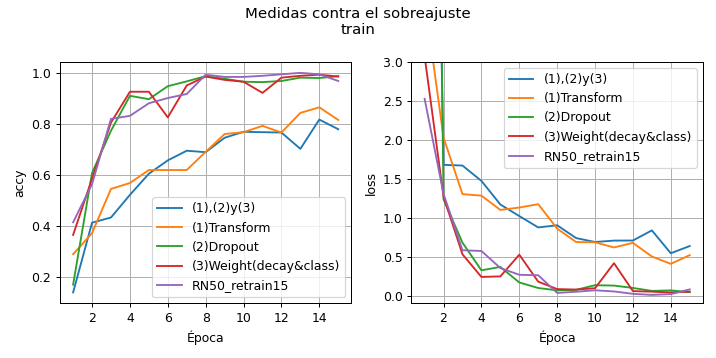

In [6]:
plot("train", "sobreajuste", "Medidas contra el sobreajuste")

<IPython.core.display.Javascript object>


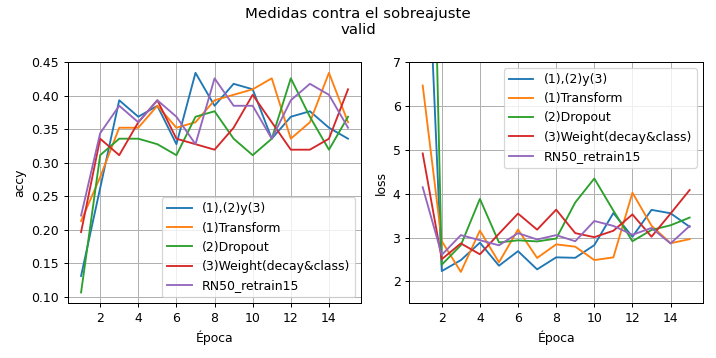

In [7]:
plot("valid", "sobreajuste", "Medidas contra el sobreajuste")

Podemos observar que los efectos más drásticos se obtienen al utilizar aumentación de datos en el conjunto de entrenamiento, mientras que los efectos de dropout o weights no son muy notorios. En las curvas de la etapa de validación podemos ver que la utilización de las tres técnicas en conjunto (1, 2, y 3) entrega resultados comparables (en ocasiones levemente mejores) al de la transformación por sí sola, por lo que en las pruebas siguientes utilizaremos las tres para entrenar nuestros modelos.


## Selección de optimizador

Compararemos los optimizadores `SGD` (con y sin momentum), `Adam` y `AdamW` con la tasa de aprendizaje y el weight_decay que hemos utilizado hasta el momento.

```python
optimizer = torch.optim.SDG(model.parameters(),
                             lr=1e-3,
                             weight_decay=3e-4)

optimizer = torch.optim.SDG(model.parameters(),
                             lr=1e-3,
                             weight_decay=3e-4,
                             momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=3e-4)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=1e-3,
                              weight_decay=3e-4)
```

<IPython.core.display.Javascript object>


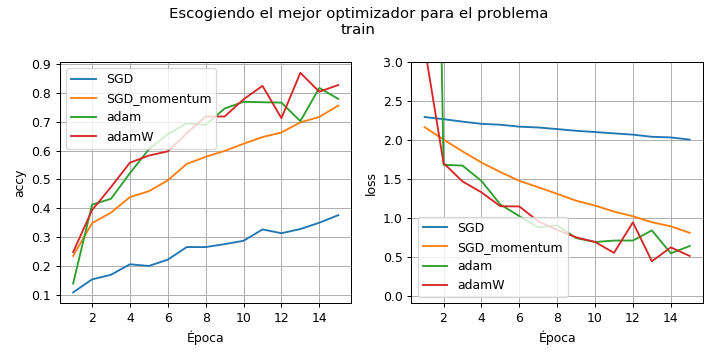

In [33]:
plot("train", "optimizadores", "Escogiendo el mejor optimizador para el problema")

<IPython.core.display.Javascript object>


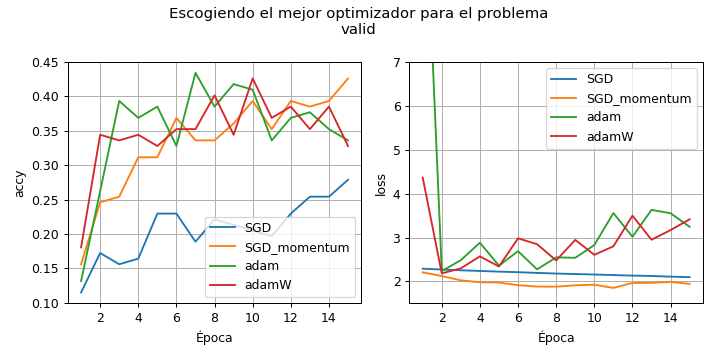

In [5]:
plot("valid", "optimizadores", "Escogiendo el mejor optimizador para el problema")

Con los hiperparámetros utilizados para compararlos, SDG sin momentum no logra aprender lo suficiente, alcanzando accuracies menores en entrenamiento y validación. Adam y AdamW se comportan de forma similar en las dos etapas, y SDG con momentum es el optimizador con mejor desempeño en la etapa de validación, con accuracy comparable a Adam y AdamW, pero con una loss menor y más estable.

Seleccionaremos SDG con momentum para continuar puliendo nuestro modelo.

## Impacto del Learning Rate 

Hasta el momento, hemos realizado todos los experimentos con una tasa de aprendizaje fija de `1e-3`, pero si quisiéramos continuar mejorando, es necesario estudiar cómo se comporta y aprende nuestro modelo al utilizar otros valores. Para esto, incrementaremos el número de épocas a 25 para ver las curvas de aprendizaje resultantes al entrenar por más tiempo, y para no descartar una tasa de aprendizaje un poco más baja que pueda generar mejores resultados a largo plazo.

<IPython.core.display.Javascript object>


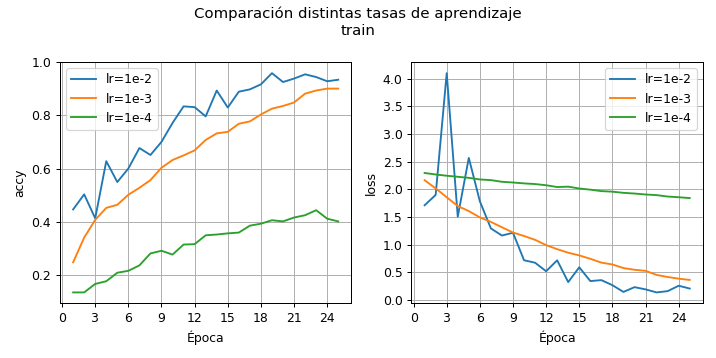

In [10]:
plot("train", "lr1", title="Comparación distintas tasas de aprendizaje")

Como era de esperarse, una tasa de aprendizaje más alta converge más rápido a una solución en la etapa de entrenamiento, pero lo hace de forma más irregular que las tasas más bajas. Podemos ver que `lr = 1e-2` se aprende el conjunto de entrenamiento con mayor facilidad que las otras dos tasas, alcanzando mejor accuracy y loss en las 25 épocas. Por el contrario, `lr = 1e-4` es demasiado baja para nuestro problema o configuración actual, llegando apenas a 40% de accuracy en entrenamiento en la totalidad de las épocas. La tasa `lr = 1e-3` que hemos utilizado hasta el momento se comporta con bastante estabilidad, pero nos interesa encontrar una aún mejor.

<IPython.core.display.Javascript object>


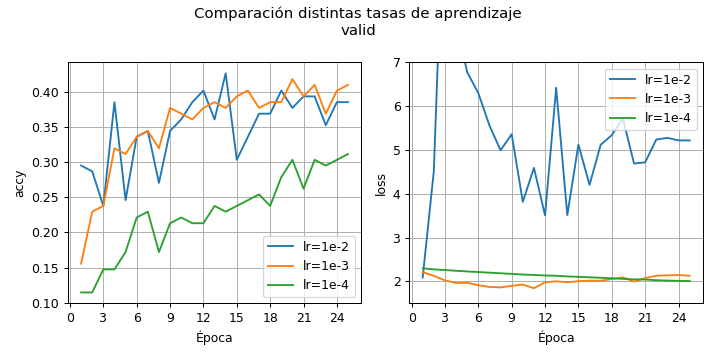

In [11]:
plot("valid", "lr1", title="Comparación distintas tasas de aprendizaje")

En validación ocurre algo similar a la etapa de entrenamiento, `lr = 1e-2` es muy irregular en accuracy y loss, pero con un resultado comparable al de `lr = 1e-3` en la primera métrica. Su loss, en cambio, nunca baja al nivel de las otras dos tasas de aprendizaje. Se observa que la tasa menor `lr = 1e-4` mejora constantemente en ambas métricas a medida que avanza en las épocas, pero lo hace de una forma muy lenta para nuestras necesidades.

## Tasa de aprendizaje fija y con decaimiento

```python
lr=1e-2
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
```

Reducir la tasa de aprendizaje en un factor factor de 10 cada 5 épocas.

https://pytorch.org/ignite/_modules/ignite/contrib/handlers/param_scheduler.html
```python

scheduler = CosineAnnealingScheduler(optimizer,
                                     "lr",
                                     start_value=5e-3,
                                     end_value=1e-3,
                                     cycle_size=len(train_loader))
```
Reduce la tasa de aprendizaje de 'start_value' a 'end_value' en cada ciclo. Al fijar el 'cycle_size' como el largo del train_loader, cada ciclo corresponde a una época.
El annealing toma la forma de la primera mitad de la gráfica de la función Coseno.

Incorporamos también un valor intermedio con respecto a los valores fijos utilizados anteriormente: `lr = 5e-3`

<IPython.core.display.Javascript object>


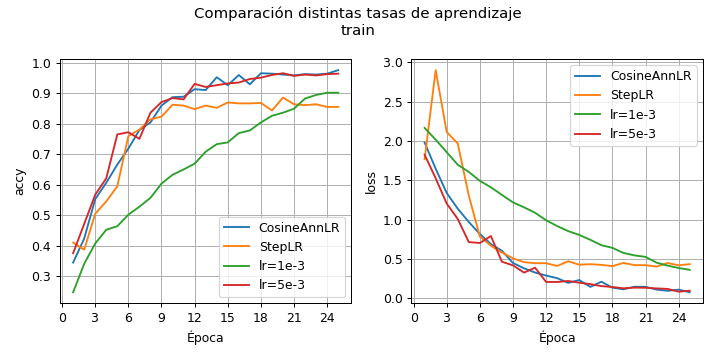

In [12]:
plot("train", "lr2", title="Comparación distintas tasas de aprendizaje")

<IPython.core.display.Javascript object>


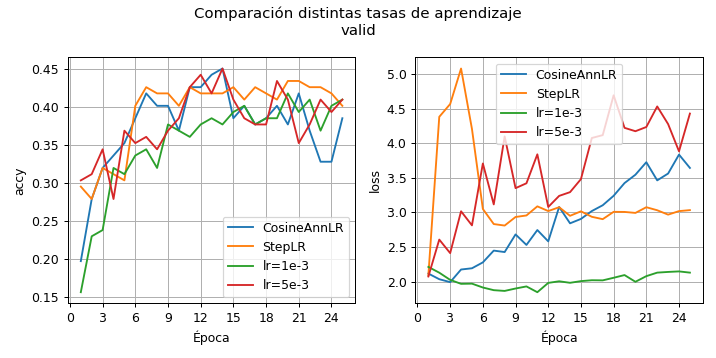

In [13]:
plot("valid", "lr2", title="Comparación distintas tasas de aprendizaje")

En entrenamiento, `StepLR` y `lr = 5e-3` se comportaron de forma similar con mejores accuracy y loss que `lr = 1e-3`. En la etapa de validación, `lr = 5e-3` logró lo que hasta el momento es nuestra mejor accuracy en esta etapa, alcanzando un 45%. `StepLR` comienza de forma irregular al partir con una tasa de aprendizaje más alta, pero en las épocas más tardías, se estabiliza en una accuracy cercana a 42% y una loss que se ubica entre la de `lr = 5e-3` y la de `lr = 1e-3`.

En el caso de `CosineAnnealing`, los resultados son similares a `lr = 5e-3` en ambas etapas. En validación, también alcanza un 45% de accuracy con una loss ligeramente mejor. Todo esto con curvas bastante más suaves.


De acuerdo a los resultados anteriores, intentamos buscar el modelo con mejor rendimiento en validación utilizando CosineAnnealing y StelpLR. Consideramos tanto el de mejor accuracy como el de mejor loss, sin embargo, como se observó en gran parte de las curvas de aprendizaje, la loss muchas veces disminuye un poco durante algunas épocas iniciales para luego oscilar en ciertos valores o subir (no necesariamente explotando).

Como una loss menor no necesariamente implica una mejor rendimiento o una mejor accuracy final (si la loss es mayor, el modelo puede predecir correctamente con menor seguridad o puede estar más seguro de sus errores), optamos por seleccionar el modelo con mayor accuracy considerando 15 épocas de entrenamiento por sobre un modelo con loss baja pero con solo una o dos épocas de entrenamiento.


# El modelo final


```python
model = models.resnet50(pretrained=True)

layers_to_train = 15

model.fc = nn.Sequential(nn.Dropout(p=0.4),
                         torch.nn.Linear(neurons, 10))

lr = 7e-3
weight_decay = 1e-3

optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                            weight_decay=weight_decay,
                            momentum=0.9
                            )

max_epochs = 15

scheduler = StepLR(optimizer, step_size=4, gamma=0.5)
```

<IPython.core.display.Javascript object>


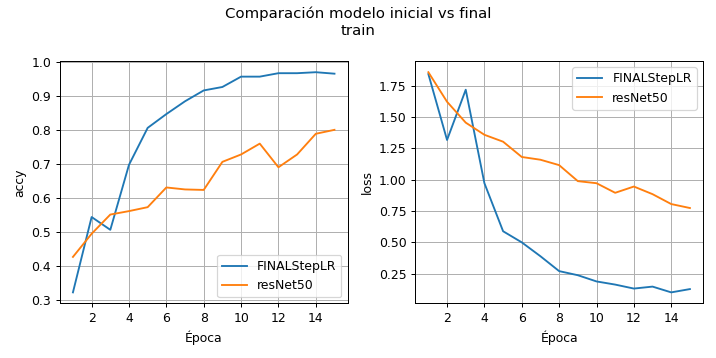

In [14]:
plot("train", "final", title="Comparación modelo inicial vs final")

<IPython.core.display.Javascript object>


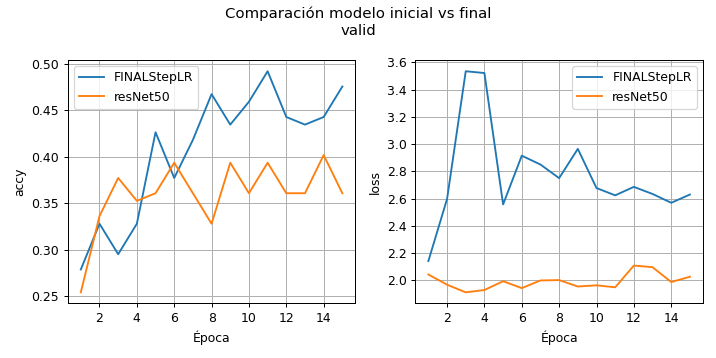

In [15]:
plot("valid", "final", title="Comparación modelo inicial vs final")

En validación, la loss de nuestro modelo final incrementó en algunas décimas, sin embargo, también lo hizo la accuracy pasando de 40% a alrededor de 49% en los puntos máximos.

Cabe destacar que las modificaciones que hicimos al modelo base, como incorporación de medidas contra el sobreajuste y el uso de schedulers, requieren hiperparámetros adicionales (weight_decay, droput_rate, min/max lr, step, etc) cuyo ajuste más preciso podría mejorar el rendimiento de nuestro modelo. Los valores que utilizamos, en gran parte, fueron seleccionados tras experimentar con estos y observar las curvas de aprendizaje, sin tener en cuenta todas las combinaciones posibles que surgen debido a las limitaciones de tiempo/capacidad de cómputo como para realizar un barrido más extensivo de valores.

# Evaluando el modelo final

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import datasets
import torch
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
np.random.seed(0)
torch.manual_seed(0)

In [17]:
simple_transform = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                        std=(0.229, 0.224, 0.225))])
test_data = datasets.ImageFolder(root='data/test/',
                                 transform=simple_transform)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=16,
                                          shuffle=False)

In [18]:
model = models.resnet50(pretrained=False)
neurons = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(p=0.4),
                         torch.nn.Linear(neurons, 10))

model.load_state_dict(torch.load('best_FINALStepLR_val_acc=0.4918.pt'))

<All keys matched successfully>

In [19]:
model.eval()
device = torch.device('cuda:0')
model.to(device)
test_targets = np.array(test_data.targets)
prediction_test = []
entropy = []
for mbdata, label in test_loader:
    mbdata = mbdata.to(device)
    logits = model.forward(mbdata).cpu()
    probs = torch.nn.Softmax(dim=1)(logits)
    entropy.append(-(logits*probs).sum(1).detach().numpy())
    prediction_test.append(logits.argmax(dim=1).detach().numpy())

prediction_test = np.concatenate(prediction_test)
entropy = np.concatenate(entropy)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.yticks(tick_marks, labels)
    plt.xticks(tick_marks, labels, rotation=90)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')

cm = confusion_matrix(y_true=test_targets, y_pred=prediction_test)

In [21]:
# 0 : 'Art Nouveau o Modernismo'
label_dict = {
     'Modernismo' : 0,
     'Barroco' : 1,
     'Expresionismo' : 2,
     'Impresionismo' : 3,
     'Neoclasicismo' : 4,
     'Posimpresionismoo' : 5,
     'Realismo' : 6,
     'Romanticismo' : 7,
     'Surrealismo' : 8,
     'Symbolism' : 9
}
lbs = list(label_dict.keys())

<IPython.core.display.Javascript object>


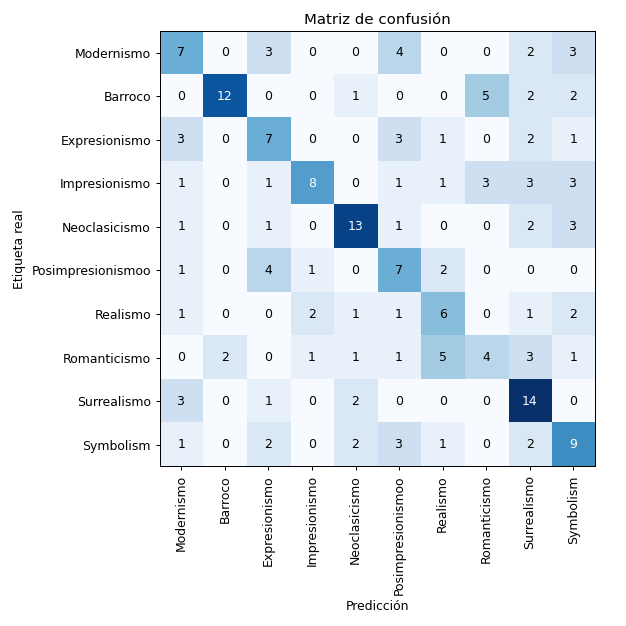

                   precision    recall  f1-score   support

       Modernismo      0.389     0.368     0.378        19
          Barroco      0.857     0.545     0.667        22
    Expresionismo      0.368     0.412     0.389        17
    Impresionismo      0.667     0.381     0.485        21
    Neoclasicismo      0.650     0.619     0.634        21
Posimpresionismoo      0.333     0.467     0.389        15
         Realismo      0.375     0.429     0.400        14
     Romanticismo      0.333     0.222     0.267        18
      Surrealismo      0.452     0.700     0.549        20
        Symbolism      0.375     0.450     0.409        20

         accuracy                          0.465       187
        macro avg      0.480     0.459     0.457       187
     weighted avg      0.497     0.465     0.467       187



In [22]:
plot_confusion_matrix(cm, labels=lbs)
print(classification_report(test_targets,
                            prediction_test,
                            target_names=lbs,
                            digits=3))

La diagonal de la matriz de confusión y la accuracy final correspondiente nos muestran que el modelo efectivamente logró clasificar una parte considerable de las imágenes de prueba. El mejor rendimiento lo obtuvo en las imágenes pertenecientes al estilo `Barroco`, con un f1-score de 0.667. Durante las pruebas que realizamos, vimos de manera frecuente que nuestros modelos confundieran este estilo con `Romanticismo`, principalmente prediciendo Barroco cuando era la otra. En este caso tuvo más errores al hacer la predicción opuesta.

Otra clase que destacó en lo positivo fue `Neoclasicismo` con un f1-score de 0.634, estilo que confundió principalmente con `Surrealismo` y `Simbolismo`.

Romanticismo fue la clase en la que el modelo tuvo el peor desempeño, con un recall cercano a **1 de 5**, confundiéndose muchas veces con `Realismo` y `Surrealismo`.


### Revisión de casos mal clasificados

Observemos una de las imágenes que el modelo se equivocó al no predecir su etiqueta correcta (Romanticismo):

<IPython.core.display.Javascript object>


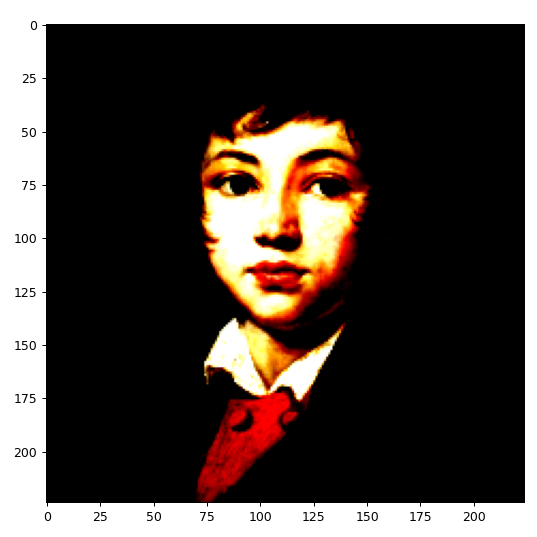

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [23]:
wc = label_dict.get('Romanticismo')
true_labels = np.array(test_data.targets)
idx = np.where((true_labels == wc) & ~(prediction_test == wc))[0]
i = idx[1]

img1 = np.transpose(test_data[i][0].numpy(), (1, 2, 0))
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
ax.imshow(img1)
plt.show()

<IPython.core.display.Javascript object>


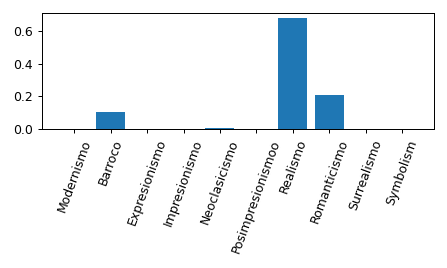

In [24]:
device = torch.device('cpu')
model.to(device)

image, label = test_data[i]
y = torch.nn.Softmax(dim=1)(model.forward(image.unsqueeze(0)))
fig, bx = plt.subplots(figsize=(5, 3), tight_layout=True)
bx.bar(range(10), height=y.detach().numpy()[0])
bx.set_xticks(range(10))
bx.set_xticklabels(list(label_dict.keys()), rotation=70)
plt.show()

Para este error en particular ('portrait of aa chelishchev'), la etiqueta correcta se encuentra en segundo lugar en cuanto a las probabilidades predichas por el modelo. Intentemos comparar esta pieza de arte con una que el modelo predijo correctamente como `Realismo` (idealmente también el retrato de una persona).

<IPython.core.display.Javascript object>


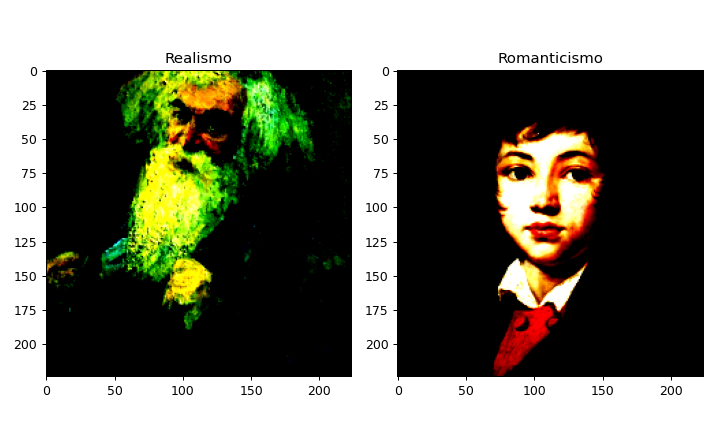

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [25]:
wc = label_dict.get('Realismo')
idx = np.where((true_labels == wc) & (prediction_test == wc))[0]
i = idx[4] #ilya-repin_portrait-of-the-author-ieronim-yasinsky-1910

fig, ax = plt.subplots(1, 2,figsize=(8, 5), tight_layout=True)
ax[0].imshow(np.transpose(test_data[i][0].numpy(), (1, 2, 0)))
ax[0].set_title("Realismo")
ax[1].imshow(img1)
ax[1].set_title("Romanticismo")
plt.show()

Solo viendo el contenido y las características de ambas imagenes (rostro de una persona, fondo negro), y sin más conocimientos sobre la identidad, contexto histórico, etc se hace un poco difícil identificar el estilo artístico para una persona sin muchos conocimientos en el área. Además, el preprocesamiento requerido para utilizar los modelos altera la imagen que nosotros vemos (normalización) y reduce la cantidad de información disponible (recorte). 

Es evidente que este problema de clasificación no es una tarea sencilla, ya que el contenido, como animales, paisajes, edificios, o como en este caso, el retrato de una persona, puede ser el mismo en dos o mas clases distintas. El modelo debe ser capaz de identificar las sutilezas que diferencian los estilos, los que además pueden compartir otras similitudes en cuanto a inspiraciones, temáticas, los materiales o técnicas utilizadas. De igual manera, existen estilos con diferencias más notorias que el modelo es capaz de identificar con mayor facilidad.


# Conclusión

A pesar de que se trabajó con una base de datos pequeña, el uso de modelos pre-entrenados, en conjunto con técnicas para enfrentar el sobreajuste y la optimización de hiperparámetros nos permitió alcanzar una accuracy final que podríamos considerar aceptable debido a la complejidad del problema, aunque no podemos descartar que sea posible mejorar nuestro modelo final, ya sea aumentando el número de épocas de entrenamiento, haciendo una búsqueda más fina en los hiperparámetros, mejorando las transformaciones, etc. pero las limitaciones de hardware y tiempo nos lo dificultan (el tiempo promedio por época durante los entrenamientos era de 1 min aproximadamente).

Notamos que confiar ciegamente en la loss para seleccionar el mejor modelo, que en nuestro caso significaba tomar un modelo con muy pocas épocas de entrenamiento, no resultaba en las mejores predicciones, aunque con una selección distinta de optimizador/ menor tasa de aprendizaje y más épocas, es posible que el mejor modelo efectivamente sea el de menor loss.

